# Sidecar

The goal of this notebook is to show how using [Jupyter Sidecar](https://github.com/jupyter-widgets/jupyterlab-sidecar) can help to interactively explore and understand your data.

Note that sidecar **only works in JupyterLab** and will not work in other notebook frontends like Colab.

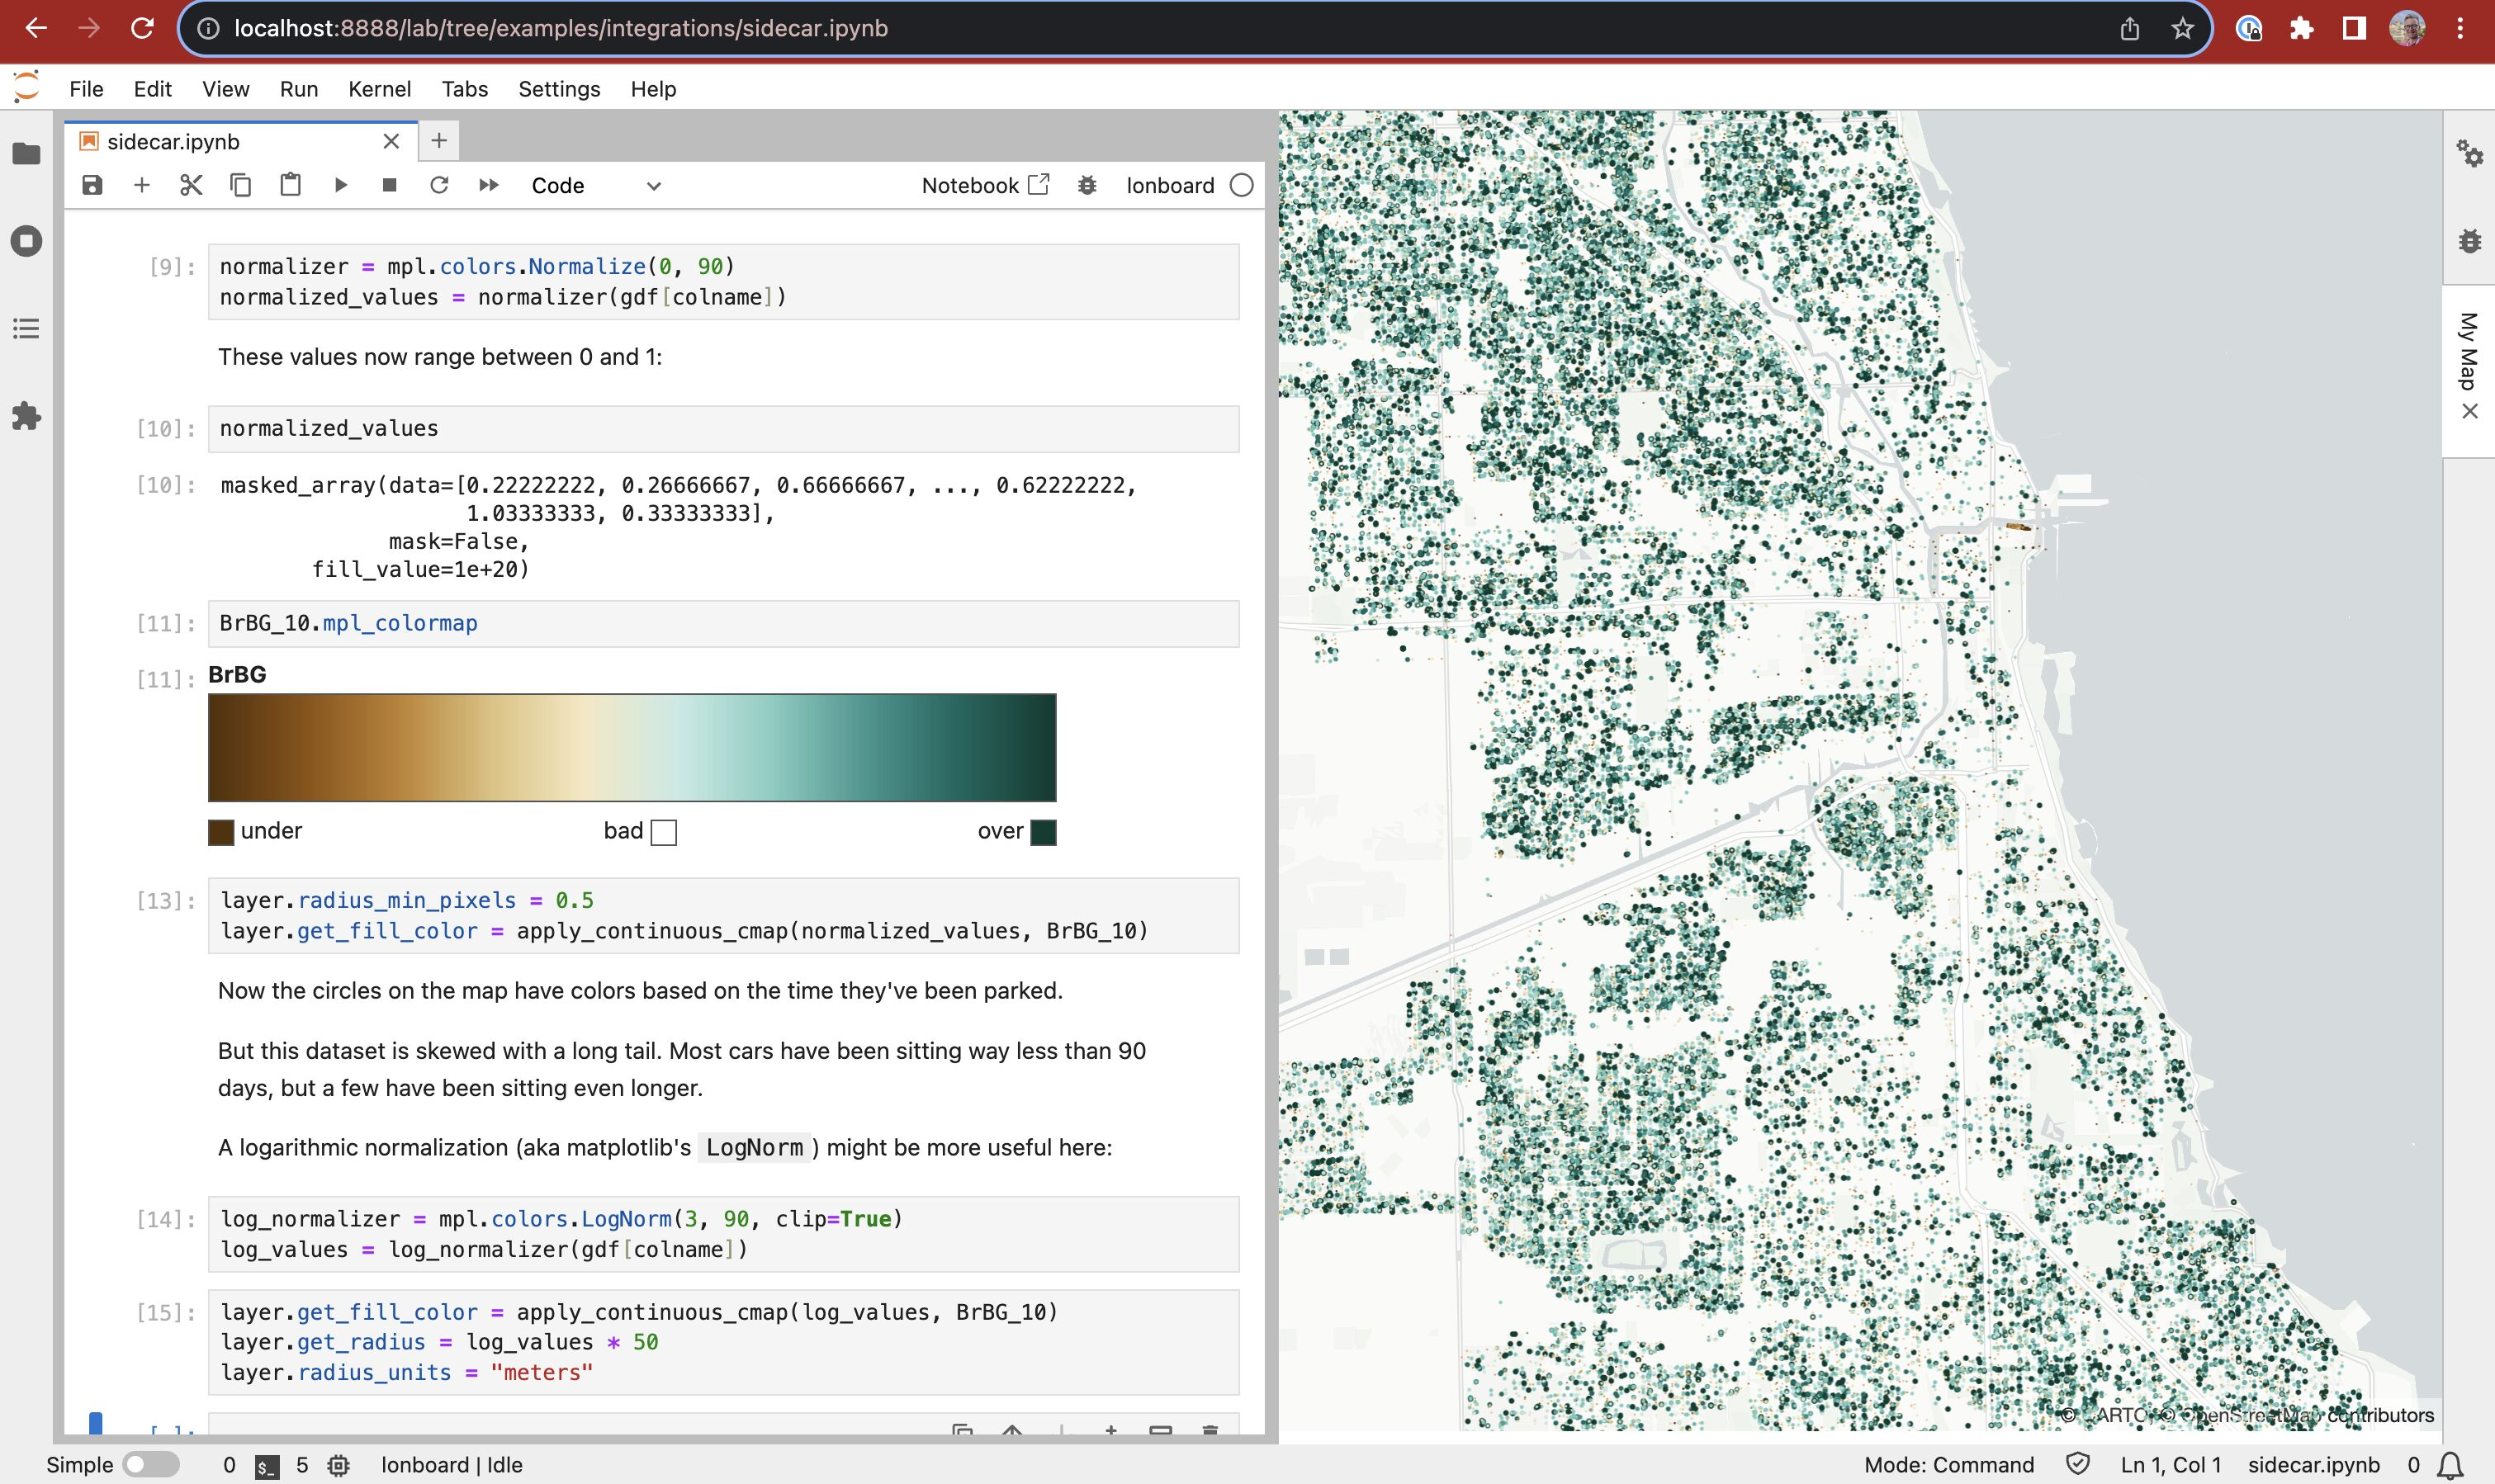

## Dependencies

- lonboard
- [sidecar](https://github.com/jupyter-widgets/jupyterlab-sidecar)
- pyogrio

Run

```
pip install sidecar pyogrio
```

if needed. You may need to restart Jupyter and/or refresh your browser tab after installing `sidecar`.

## Imports

In [1]:
import geopandas as gpd
import ipywidgets
import matplotlib as mpl
import pandas as pd
from palettable.colorbrewer.diverging import BrBG_10
from sidecar import Sidecar

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap

For this example, we'll use a dataset of [abandoned cars in Chicago](https://geodacenter.github.io/data-and-lab/1-source-and-description/). Since this is a CSV file, we need to pass in the names of the X and Y columns into the ["open options"](https://gdal.org/drivers/vector/csv.html) to pass to OGR.

In [2]:
url = "https://geodacenter.github.io/data-and-lab/data/Abandoned_Vehicles_Map.csv"
gdf = gpd.read_file(
    url,
    engine="pyogrio",
    use_arrow=True,
    X_POSSIBLE_NAMES="Longitude",
    Y_POSSIBLE_NAMES="Latitude",
    KEEP_GEOM_COLUMNS="NO",
)

This dataset has some null values for geometries. We'll remove these first:

In [3]:
gdf = gdf[gdf.geometry != None]

Let's also remove empty values from another column to make later steps easier (when modifying a single map object with lonboard, you can't change the number of rows).

In [4]:
gdf = gdf[gdf["How Many Days Has the Vehicle Been Reported as Parked?"] != ""]

We'll now initialize the `Sidecar` object, which splits the JupyterLab screen in half, creating the output area for our widget.

In [5]:
sc = Sidecar(title='My Map')

Now let's create a map layer from our `GeoDataFrame`.

The default map height is 500 pixels, but we'd like to have a taller map because it's vertical. This API may change in the future.

In [6]:
layer = ScatterplotLayer.from_geopandas(gdf)
map_ = Map(layers=[layer], _height=800)

Now we can render this inside the sidecar. You should see the map appear on the right side of your screen.

In [7]:
with sc:
    display(map_)

It's great that we can see the map, but let's customize the rendering a bit. There's a column in the data titled

> How Many Days Has the Vehicle Been Reported as Parked?

Let's use this column to visualize how long it takes to remove a car in different areas of the city.

This is a string column, so first let's convert it to a numeric value.

In [8]:
colname = "How Many Days Has the Vehicle Been Reported as Parked?"
gdf[colname] = pd.to_numeric(gdf[colname])

In order to apply a colormap onto our data, we need to normalize our values to the range of `0-1`. Matplotlib offers several normalization options. See the [tutorial](https://matplotlib.org/stable/users/explain/colors/colormapnorms.html) and the [`matplotlib.colors`](https://matplotlib.org/stable/api/colors_api.html) module.

To start, we'll do a simple linear normalization, converting from 0-90 to 0-1. Any values below 0 will be clamped to 0, and any values above 90 will be clamped to 1.

In [9]:
normalizer = mpl.colors.Normalize(0, 90)
normalized_values = normalizer(gdf[colname])

These values now range between 0 and 1:

In [10]:
normalized_values

masked_array(data=[0.22222222, 0.26666667, 0.66666667, ..., 0.62222222,
                   1.03333333, 0.33333333],
             mask=False,
       fill_value=1e+20)

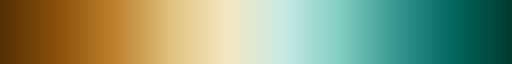

In [11]:
BrBG_10.mpl_colormap

In [12]:
layer.radius_min_pixels = 0.5
layer.get_fill_color = apply_continuous_cmap(normalized_values, BrBG_10)

Now the circles on the map have colors based on the time they've been parked. 

But this dataset is skewed with a long tail. Most cars have been sitting way less than 90 days, but a few have been sitting even longer.

A logarithmic normalization (aka matplotlib's `LogNorm`) might be more useful here:

In [13]:
log_normalizer = mpl.colors.LogNorm(3, 90, clip=True)
log_values = log_normalizer(gdf[colname])

In [14]:
layer.get_fill_color = apply_continuous_cmap(log_values, BrBG_10)
layer.get_radius = log_values * 50
layer.radius_units = "meters"